# Загрузка Pandas и очистка данных

In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt
from datetime import datetime

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [3]:
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [4]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

In [5]:
display(df.head(10))
display(df.info())

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0
5,id_5,Paris,"['French', 'Cafe', 'Fast Food']",5093.0,$,24.0,"[['Lunch Break', 'Good to Quick Bite'], ['09/0...",/Restaurant_Review-g187147-d8458643-Reviews-Le...,d8458643,0,0.0
6,id_6,Lisbon,"['European', 'Portuguese']",3704.0,$,2.0,"[[], []]",/Restaurant_Review-g189158-d8758873-Reviews-Li...,d8758873,0,0.0
7,id_7,Budapest,NaN,2330.0,NaN,NaN,"[[], []]",/Restaurant_Review-g274887-d8286886-Reviews-Be...,d8286886,0,0.0
8,id_8,Helsinki,"['European', 'Scandinavian']",771.0,NaN,2.0,"[['Big group supper', 'Good food but very slow...",/Restaurant_Review-g189934-d12947542-Reviews-B...,d12947542,0,0.0
9,id_9,Stockholm,['Italian'],605.0,NaN,13.0,"[['Good food', 'Good pizza'], ['12/02/2017', '...",/Restaurant_Review-g189852-d12716384-Reviews-I...,d12716384,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


None

## Создание новых признаков

### Рейтинг кухни

Создание признаков на основе данных о кухнях ресторанов
  - Cuisine_count - количество кухонь ресторана
  - Cuisines_ranking - рейтинг кухонь ресторана (вычисляется из Ranking и Cuisine Style)


In [6]:
cuisines_set = set()  # множество из всех кухонь датасета
cuisines_counter = Counter()  # какая кухня сколько раз встречается в датасете

# заполнение cuisines_counter и cuisines_set:
for cuisines in df['Cuisine Style']:
    if (type(cuisines) == float):
        continue
    cuisines = cuisines[2:-2]
    cuisines = cuisines.split("', '")
    for cuisine in cuisines:
        cuisines_set.add(cuisine)
        cuisines_counter[cuisine] += 1


# Добавляем столбец Cuisine_count
df['Cuisine_count'] = df['Cuisine Style'].apply(
    lambda x: 1 if (type(x) == float) else len(x[2:-2].split("', '")))

# среднее количество кухонь в ресторане
cuisines_count_mean = df['Cuisine_count'].mean()

# Добавляем столбец с признаком "рейтинг кухонь ресторана"
cuisines_ranking = pd.Series()
for cuisine in cuisines_set:
    cuisines_ranking[cuisine] = df[df['Cuisine Style'].str.contains(
        cuisine) == True]['Ranking'].median()
cuisines_ranking_mean = cuisines_ranking.median()


def get_cuisines_rating(cuisines):
    # Вычисление рейтинга ресторана относительно его кухонь
    if (type(cuisines) == float):
        return cuisines_ranking_mean * cuisines_count_mean
    cuisines = cuisines[2:-2]
    cuisines = cuisines.split("', '")
    return cuisines_ranking[cuisines].sum()


df['Cuisines_ranking'] = df['Cuisine Style'].apply(get_cuisines_rating)

### Price range

Обработка признака price range и заполнение пустых значений

In [7]:
def get_number_of_price_range(value):
    #   Функция форматирирует столбец из строкого в числовой
    if value == '$':
        return 1
    elif value == '$$ - $$$':
        return 2
    elif value == '$$$$':
        return 3
    else:
        return None


df['Price Range'] = df['Price Range'].apply(get_number_of_price_range)

In [8]:
# fig = plt.figure()
# axes = fig.add_axes([0, 0, 1, 1])

# median = df['Number of Reviews'].median()
# iqr = df['Number of Reviews'].quantile(0.75) - df['Number of Reviews'].quantile(0.25)
# perc25 = df['Number of Reviews'].quantile(0.25)
# perc75 = df['Number of Reviews'].quantile(0.75)
# print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
#       , "IQR: {}, ".format(iqr),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))


# axes.hist(x = df[df['Price Range'] == 2]['Number of Reviews'].loc[df['Ranking'].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)], width=200, label = '\$\$', bins=25)
# axes.hist(x = df[df['Price Range'] == 1]['Number of Reviews'].loc[df['Ranking'].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)], width=-200, label = '\$', bins=25)
# axes.hist(x = df[df['Price Range'] == 3]['Number of Reviews'].loc[df['Ranking'].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)], width=80, label = '\$\$\$', bins=25)
# axes.legend(loc = 1)

# df.groupby('Price Range').mean()

# Заполнение Price Range средним значением
price_range_mean = df['Price Range'].median()
df['Price Range'] = df['Price Range'].fillna(price_range_mean)

### Анализ влияния города на рейтинг и ранг

Добавление признаков City_ranking, City_price_range, City_Number_of_Reviews, основанных на группировании сумм признаков по городам. На практике, наибольший прирост MAE показала именно сумма

In [9]:
# groupby через агрегирующую функцию суммы
df_city_groupby_med = df.groupby('City').sum()

# Добавляем столбец City_ranking
df['City_ranking'] = df['City'].apply(
    lambda x: df_city_groupby_med['Ranking'][x])

# Добавляем столбец city_price_range_sum
df['City_price_range'] = df['City'].apply(
    lambda x: df_city_groupby_med['Price Range'][x])

# Добавляем столбец number_review_sum
df['City_Number_of_Reviews'] = df['City'].apply(
    lambda x: df_city_groupby_med['Number of Reviews'][x])

## Обработка Reviews

Создание столбцов:
 - Reviews_date - даты ревью ресторана
 - Reviews_list - текст ревью
 - First_review_date - дата первого ревью ресторана
 - Review_timedelta - разница между датами ревью ресторана

In [10]:
# Заполняем reviews средним значением
reviews_mean = float(round(df['Number of Reviews'].mean()))  # ~125
df['Number of Reviews'] = df['Number of Reviews'].fillna(reviews_mean, axis=0)

In [11]:
def review_splitter(x, i):
    # Разбивает значение Reviews на две части.
    # В зависимости от i, возвращает либо даты ревью, либо сами ревью
    if type(x) == str:
        return x[2:-2].split('], [')[i]
    else:
        return None


df['Reviews_date'] = df['Reviews'].apply(review_splitter, args=(1, ))
df['Reviews_list'] = df['Reviews'].apply(review_splitter, args=(0, ))


def get_first_review_date(value):
    # Возвращает дату первого ревью в формате datetime
    if not value:
        return None
    elif (len(value.split(', ')) == 2):
        return datetime.strptime(value[1:-1].split("', '")[1], '%m/%d/%Y')
    else:
        return datetime.strptime(value[1:-1], '%m/%d/%Y')


df['First_review_date'] = df['Reviews_date'].apply(get_first_review_date)
df['First_review_date'] = df['First_review_date'].apply(lambda x: x.dayofweek)
# Заполнение столбца First_review_date средними значениями
df['First_review_date'] = df['First_review_date'].fillna(
    df['First_review_date'].mean())


def get_timedelta_from_review_date(value):
    # Возвращает дельту между первым и вторым ревью
    if (not value) or (len(value.split(', ')) == 1):
        return None
    else:
        date_min = datetime.strptime(value[1:-1].split("', '")[1], '%m/%d/%Y')
        date_max = datetime.strptime(value[1:-1].split("', '")[0], '%m/%d/%Y')
        return abs(date_max - date_min).days


df['Review_timedelta'] = df['Reviews_date'].apply(
    get_timedelta_from_review_date)

In [12]:
# Заполнение столбца Review_timedelta средними значениями

review_timedelta_value = df['Review_timedelta'].value_counts().mean()
df['Review_timedelta'] = df['Review_timedelta'].fillna(review_timedelta_value)

### Обработка Reviews_list и вытаскивание из них положительных и отрицательных характеристик

 - Reviews_rating - положительность отзывов ресторана (от большей к меньшей)

In [13]:
# sys.stdout = open('Reviews_list1.txt', 'w', encoding='utf-8')
# for line in df['Reviews_list']:
#     print(line)

In [14]:
df['Reviews_list'] = df['Reviews_list'].apply(lambda x: x.lower() if (type(x) == str) else None)


def reviews_counter(text):

    # В зависимости от характера отзыва, будет возвращено значение
    # либо больше, либо меньше
    # Если значение равно нулю - значит либо данных в отзыве скорее
    # всего недостаточно, либо либо отзыв нейтральный
    if type(text) != str:
        return None
    count = 0

    bad_list = set(['bad', 'too bad', 'bad food', 'bad service', 'bad place', 'disappoint',
                    'not good', 'not good place', 'worse food', 'worse service', 'worse place',
                    'terrible', 'terrible food', 'terrible place', 'avoid',
                    'terrible service', 'horrible', 'horrible food', 'horrible place',
                    'awful', 'harmful', 'adverse'])

    good_list = set(['good', 'great', 'super', 'amazing', 'amazing food', 'amazing place',
                     'good food', 'good service', 'music', 'perfect'
                     'nice food', 'nice place', 'nice service', 'friendly',
                     'best food', 'best service', 'best place', 'love',
                     'lovely', 'lovely food', 'lovely place', 'not bad',
                     'very tasty', 'excellent', 'Beautiful', 'enjoyable'])

    for phrase in good_list:
        if phrase in text:
            count += 1
    for phrase in bad_list:
        if phrase in text:
            count -= 1
    return count


df['Reviews_rating'] = df['Reviews_list'].apply(reviews_counter)

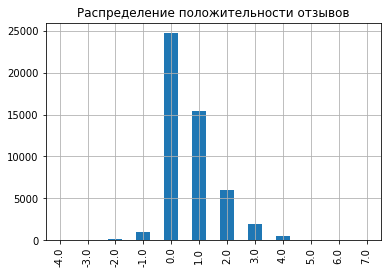

In [15]:
# Какое распределение получилось в итоге для признака
df['Reviews_rating'].value_counts().sort_index().plot(
    kind='bar', grid=True, title='Распределение положительности отзывов')

# Можно наблюдать, что большинство отзывов носят положительный характер

In [16]:
# Заполнение пропущенных значений
df['Reviews_rating'] = df['Reviews_rating'].fillna(df['Reviews_rating'].median())

### Добавление dummy variables и удаление ненужных для обучения столбцов

,Ranking,Price Range,Number of Reviews,sample,Rating,Cuisine_count,Cuisines_ranking,City_ranking,City_price_range,City_Number_of_Reviews,First_review_date,Review_timedelta,Reviews_rating
Ranking,1.000000,-0.026334,-0.214359,0.006271,-0.109897,-0.322408,-0.097623,0.692124,0.708653,0.655905,-0.009263,0.079918,-0.143539
Price Range,-0.026334,1.000000,0.112717,-0.003419,-0.012176,0.002816,0.012235,0.007413,0.007840,-0.023015,0.008589,-0.031886,-0.008584
Number of Reviews,-0.214359,0.112717,1.000000,0.002333,0.011001,0.392993,0.216737,0.016261,0.020766,0.081106,0.007487,-0.115638,0.097296
sample,0.006271,-0.003419,0.002333,1.000000,0.936543,-0.003202,-0.001801,0.003452,0.004688,0.003715,-0.002734,-0.005937,-0.007937
Rating,-0.109897,-0.012176,0.011001,0.936543,1.000000,0.034506,0.017477,-0.013471,-0.015322,-0.006834,-0.002759,-0.026783,0.037352
Cuisine_count,-0.322408,0.002816,0.392993,-0.003202,0.034506,1.000000,0.743933,-0.004226,-0.029169,0.031475,0.010771,-0.147820,0.212489
Cuisines_ranking,-0.097623,0.012235,0.216737,-0.001801,0.017477,0.743933,1.000000,0.125774,0.108135,0.143096,0.006212,-0.129816,0.114051
City_ranking,0.692124,0.007413,0.016261,0.003452,-0.013471,-0.004226,0.125774,1.000000,0.976320,0.905809,-0.002496,-0.011579,0.037367
City_price_range,0.708653,0.007840,0.020766,0.004688,-0.015322,-0.029169,0.108135,0.976320,1.000000,0.918952,-0.002267,-0.007658,0.019990
City_Number_of_Reviews,0.655905,-0.023015,0.081106,0.003715,-0.006834,0.031475,0.143096,0.905809,0.918952,1.000000,-0.002015,-0.020786,0.029568


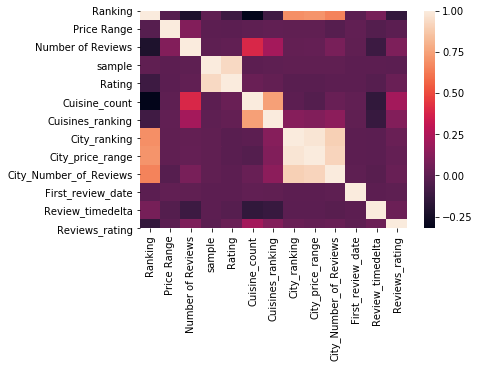

In [17]:
display(df.corr())
display(sns.heatmap(df.corr()))

In [18]:
# Создаём dummy variables для столбца 'Cuisine Style'
for cuisine in cuisines_set:
    df[cuisine] = df['Cuisine Style'].apply(
        lambda x: 1 if (cuisine in str(x)) else 0)
# df.head(10)

In [19]:
# Удаляем лишние столбцы
for column in df.columns:
    if ((df[column].dtype == 'O') and (df[column].name != 'Restaurant_id')):
        df = df.drop(column, axis=1)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [22]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
train_data = df.query('sample == 1').drop(['Restaurant_id', 'sample'], axis=1)
test_data = df.query('sample == 0').drop(['Restaurant_id', 'sample'], axis=1)

X = train_data.drop(['Rating'], axis=1)
y = train_data.Rating.values
# X = df.drop(['Restaurant_id', 'Rating'], axis=1)
# y = df['Rating']

In [23]:
display(X.info())
display(list(X.columns))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 10000 to 49999
Columns: 136 entries, Ranking to Nepali
dtypes: float64(10), int64(126)
memory usage: 41.8 MB


None

['Ranking',
 'Price Range',
 'Number of Reviews',
 'Cuisine_count',
 'Cuisines_ranking',
 'City_ranking',
 'City_price_range',
 'City_Number_of_Reviews',
 'First_review_date',
 'Review_timedelta',
 'Reviews_rating',
 'Burmese',
 'Azerbaijani',
 'Cafe',
 'Delicatessen',
 'Wine Bar',
 'Pizza',
 'Indian',
 'Sushi',
 'Central American',
 'Peruvian',
 'Vietnamese',
 'Mediterranean',
 'Kosher',
 'Welsh',
 'Mongolian',
 'Pakistani',
 'Australian',
 'New Zealand',
 'Dutch',
 'Ethiopian',
 'Lebanese',
 'Vegan Options',
 'Portuguese',
 'Danish',
 'Bar',
 'Halal',
 'Grill',
 'Southwestern',
 'Healthy',
 'Indonesian',
 'Austrian',
 'Greek',
 'Contemporary',
 'Arabic',
 'Brew Pub',
 'Ecuadorean',
 'Belgian',
 'Colombian',
 'Ukrainian',
 'Russian',
 'Italian',
 'Minority Chinese',
 'Middle Eastern',
 'Georgian',
 'Slovenian',
 'Salvadoran',
 'International',
 'Jamaican',
 'Central European',
 'Fujian',
 'Sri Lankan',
 'Persian',
 'Croatian',
 'Street Food',
 'Swedish',
 'Taiwanese',
 'Romanian',
 'Y

In [24]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [25]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаём, обучаем и тестируем модель

In [26]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [27]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [28]:
print('MAE:', metrics.mean_absolute_error(
    y_test, y_pred))

MAE: 0.210044


### Submission

In [29]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,Cuisine_count,Cuisines_ranking,City_ranking,City_price_range,City_Number_of_Reviews,First_review_date,...,Moroccan,Norwegian,Chilean,British,German,Afghani,Mexican,Native American,Soups,Nepali
1665,1829.0,2.0,201.0,0.0,6,7026.50000,42380707.0,11770.0,680827.0,2.000000,...,0,0,0,0,0,0,0,0,0,0
5920,15685.0,2.0,2.0,0.0,1,4898.84712,58764705.0,13393.0,933770.0,2.000000,...,0,0,0,0,0,0,0,0,0,0
2153,11783.0,2.0,8.0,0.0,1,4898.84712,58764705.0,13393.0,933770.0,1.000000,...,0,0,0,0,0,0,0,0,0,0
9302,4062.0,2.0,14.0,0.0,2,4074.00000,42380707.0,11770.0,680827.0,3.031419,...,0,0,0,0,0,0,0,0,0,0
9106,900.0,2.0,50.0,0.0,4,5615.50000,8805905.0,5038.0,155923.0,2.000000,...,0,0,0,0,1,0,0,0,0,0
160,436.0,2.0,177.0,0.0,6,5116.00000,804379.0,1584.0,73670.0,5.000000,...,0,0,0,0,0,0,0,0,0,0
2667,400.0,2.0,67.0,0.0,3,4521.00000,1568991.0,2226.0,82386.0,4.000000,...,0,0,0,0,0,0,0,0,0,0
6453,8417.0,2.0,4.0,0.0,1,2758.00000,16733413.0,7306.0,357185.0,3.031419,...,0,0,0,0,0,0,0,0,0,0
3908,1054.0,2.0,986.0,0.0,3,4330.50000,7691228.0,4631.0,728235.0,1.000000,...,0,0,0,0,0,0,0,0,0,0
2905,1786.0,2.0,124.0,0.0,1,4898.84712,804379.0,1584.0,73670.0,3.031419,...,0,0,0,0,0,0,0,0,0,0


In [30]:
test_data = test_data.drop(['Rating'], axis=1)

In [31]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [33]:
predict_submission = regr.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [34]:
predict_submission

array([2.99 , 4.19 , 4.48 , ..., 3.045, 4.495, 4.22 ])

In [35]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,2.990
1,id_1,4.190
2,id_2,4.480
3,id_3,4.375
4,id_4,4.465
5,id_5,4.365
6,id_6,1.975
7,id_7,2.425
8,id_8,4.250
9,id_9,4.635
